In [1]:
import numpy as np
import matplotlib.pylab as plt
import corner
import numpy as np
import glob
from PTMCMCSampler import PTMCMCSampler

%matplotlib inline

Do not have mpi4py package.
Do not have emcee package


## Define the likelihood and posterior

Functions must read in parameter vector and output log-likelihood or log-prior. Usually easiest to use a class if you need to store some other data or parameters

In [2]:
class GaussianLikelihood(object):
    
    def __init__(self, ndim=2, pmin=-10, pmax=10):
        
        self.a = np.ones(ndim)*pmin
        self.b = np.ones(ndim)*pmax
        
        # get means
        self.mu = [2]*ndim

        # ... and a positive definite, non-trivial covariance matrix.
        cov  = 0.5-np.random.rand(ndim**2).reshape((ndim, ndim))
        cov  = np.triu(cov)
        cov += cov.T - np.diag(cov.diagonal())
        self.cov  = np.dot(cov,cov)

        # Invert the covariance matrix first.
        self.icov = np.linalg.inv(self.cov)
        
    def lnlikefn(self, x):
        diff = x - self.mu
        return -np.dot(diff,np.dot(self.icov, diff))/2.0
    
    def lnpriorfn(self, x):
        
        if np.all(self.a <= x) and np.all(self.b >= x):
            return 0.0
        else:
            return -np.inf     


## Setup Gaussian model class

In [3]:
ndim = 2
pmin, pmax = 0.0, 10.0
glo = GaussianLikelihood(ndim=ndim, pmin=pmin, pmax=pmax)

## Setup sampler

Need to initalize the sample at ```p0``` and give an inital jump covariance matrix ```cov```.

In [4]:
# Set the start position and the covariance
p0 = np.random.uniform(pmin, pmax, ndim)
cov = np.eye(ndim) * 0.1**2

In [5]:
sampler = PTMCMCSampler.PTSampler(ndim, glo.lnlikefn, glo.lnpriorfn, np.copy(cov), outDir='./chains')

## Jump Proposals

We have the option to choose whatever jump proposals we would like to use in our analysis. Here, we will use the `Uniform` jump proposal (meaning all jumps are equally likely).

In [7]:
weights = {"Uniform": 1}

initialize_jump_proposal_kwargs = {"Uniform": {"pmin": 0, "pmax": 10}}

## Run Sampler for 200000 steps

Different jump proposal weights are given as integers. For example we have used a weight of 20 for all three proposals here. That means that each will be used with a probability of 20/60 = 1/3.

In [8]:
data = sampler.sample(p0, 5000, weights=weights, initialize_jump_proposal_kwargs=initialize_jump_proposal_kwargs,
               burn=500, thin=1, covUpdate=500)

Finished 80.00 percent in 0.543155 s Acceptance rate = 0.0107533
Run Complete


## Finally we can plot the data

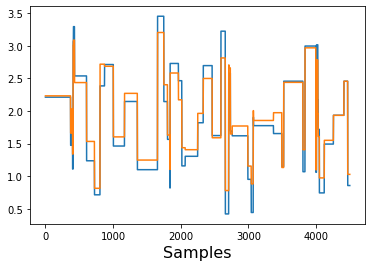

In [9]:
fig = data.plot_chains()

If you want to see what the chains looked like before burnin, you can simply run the following:

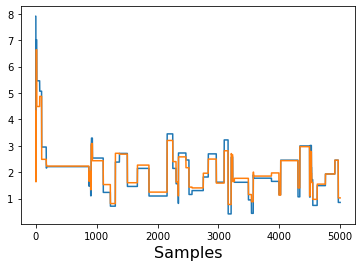

In [10]:
data.set_burnin(0)
fig = data.plot_chains()

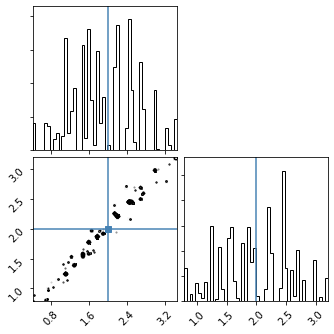

In [11]:
data.set_burnin(500)
fig = data.plot_corner(truths=glo.mu)

## Save the data

In [10]:
data.save(outfile="simple.txt")